# Apply GraphVelo to HCMV dataset

In [1]:
import sys
sys.path.insert(0, "../../..")
from paths import DATA_DIR

import numpy as np
import pandas as pd
import scanpy as sc
import dynamo as dyn

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/opt/anaconda3/envs/gv-reprod/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dyn.get_dynamo_version()

'1.4.0'

In [3]:
from graphvelo.plot import gene_trend
from graphvelo.utils import mack_score
from graphvelo.graph_velocity import GraphVelo

### Load viral gene name annotation file

In [4]:
gtf_data = pd.read_csv("https://drive.google.com/uc?export=download&id=1E_gpsRRuTrrIX8qX4biPejzjiKbD5hKd", sep="\t", header=None)
gtf_data[8] = gtf_data[8].str.extract(r'gene_id "([^"]+)"')
viral_genes_names = gtf_data[8].unique()
viral_genes_names = np.delete(viral_genes_names, np.where(viral_genes_names=='UL38')) # Exclude 0 expression viral gene
len(viral_genes_names)

66

### Load preprocessed scRNA-seq file. 
You can download the adata file via https://drive.google.com/file/d/1uH5HJ7EqjnF94oovxxCYuB4-Oc6gKBgt/view?usp=drive_link

In [5]:
adata = sc.read(DATA_DIR / "hcmv_preprocessed.h5ad")
adata

/opt/anaconda3/envs/gv-reprod/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 1454 × 28051
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_Protein', 'nFeature_Protein', 'batch', 'percent.mt', 'Demultiplex', 'TotalVir', 'TotalVirPercentage', 'CD45', 'HLA.DR', 'HCMV.Status', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters', 'clusters', 'donor', 'Cluster.Type', 'annot'
    uns: 'genes_to_use'
    obsm: 'X_umap'
    layers: 'spliced', 'unspliced'

In [6]:
valid_genes = list(viral_genes_names)+['IFNB1']

In [7]:
adata_dr = adata.copy()

/opt/anaconda3/envs/gv-reprod/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [8]:
host_genes = ~pd.Series(adata.var_names).isin(viral_genes_names.tolist()).values
viral_genes = pd.Series(adata.var_names).isin(viral_genes_names.tolist()).values
host_genes_names = adata.var_names[host_genes]
viral_genes_names = adata.var_names[viral_genes]

## Standard dynamo preprocessing criteria. 

In [9]:
dyn.pp.recipe_monocle(adata_dr, 
                      genes_use_for_norm=host_genes_names,
                      genes_to_use=viral_genes_names,
                      )
dyn.tl.reduceDimension(adata_dr, enforce=True)
dyn.pp.recipe_monocle(adata, 
                      genes_use_for_norm=host_genes_names,
                      genes_to_append=valid_genes,
                      )

|-----? dynamo.preprocessing.deprecated is deprecated.
|-----> recipe_monocle_keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_cells_key=True
|-----> recipe_monocle_keep_filtered_genes_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_genes_key=True
|-----> recipe_monocle_keep_raw_layers_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_raw_layers_key=True
|-----> apply Monocole recipe to adata...
|-----> ensure all cell and variable names unique.
|-----> ensure all data in different layers in csr sparse matrix format.
|-----> ensure all labeling data properly collapased
|-----> filtering cells...
|-----> 1454 cells passed basic filters.
|-----> filtering gene...


/var/folders/zr/17m1_r_x57q5mxr1zs8px9rh0000gn/T/ipykernel_61608/1800870191.py:1: DeprecationWarning: recipe_monocle is deprecated and will be removed in a future release. Please update your code to use the new replacement function.
  dyn.pp.recipe_monocle(adata_dr,


|-----> 7661 genes passed basic filters.
|-----> calculating size factor...
|-----> size factor normalizing the data, followed by log1p transformation.


/opt/anaconda3/envs/gv-reprod/lib/python3.8/site-packages/dynamo/preprocessing/deprecated.py:643: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["Size_Factor"] = sfs


|-----> Set <adata.X> to normalized data
|-----> applying PCA ...
|-----> <insert> X_pca to obsm in AnnData Object.
|-----> cell cycle scoring...
|-----> computing cell phase...
|-----> [Cell Phase Estimation] completed [11.7887s]
|-----> [Cell Cycle Scores Estimation] completed [0.1453s]
|-----> [recipe_monocle preprocess] completed [0.9852s]
|-----> retrieve data for non-linear dimension reduction...
|-----> [UMAP] using X_pca with n_pca_components = 30
|-----> <insert> X_umap to obsm in AnnData Object.
|-----> [UMAP] completed [4.9319s]
|-----? dynamo.preprocessing.deprecated is deprecated.
|-----> recipe_monocle_keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_cells_key=True
|-----> recipe_monocle_keep_filtered_genes_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_genes_key=True
|-----> recipe_monocle_keep_raw_layers_key is None. Using default value from DynamoAdataConfig: recipe_monocle_

/var/folders/zr/17m1_r_x57q5mxr1zs8px9rh0000gn/T/ipykernel_61608/1800870191.py:6: DeprecationWarning: recipe_monocle is deprecated and will be removed in a future release. Please update your code to use the new replacement function.
  dyn.pp.recipe_monocle(adata,


|-----> 7661 genes passed basic filters.
|-----> calculating size factor...
|-----> selecting genes in layer: X, sort method: SVR...


/opt/anaconda3/envs/gv-reprod/lib/python3.8/site-packages/dynamo/preprocessing/deprecated.py:643: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["Size_Factor"] = sfs


|-----> size factor normalizing the data, followed by log1p transformation.
|-----> Set <adata.X> to normalized data
|-----> applying PCA ...
|-----> <insert> X_pca to obsm in AnnData Object.
|-----> cell cycle scoring...
|-----> computing cell phase...
|-----> [Cell Phase Estimation] completed [7.6803s]
|-----> [Cell Cycle Scores Estimation] completed [0.0924s]
|-----> [recipe_monocle preprocess] completed [2.7466s]


In [10]:
adata.obsm['X_umap'] = adata_dr.obsm['X_umap'].copy()

In [11]:
# dyn.tl.dynamics(adata)

In [12]:
dyn.tl.neighbors(adata)

|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected


AnnData object with n_obs × n_vars = 1454 × 28051
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_Protein', 'nFeature_Protein', 'batch', 'percent.mt', 'Demultiplex', 'TotalVir', 'TotalVirPercentage', 'CD45', 'HLA.DR', 'HCMV.Status', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters', 'clusters', 'donor', 'Cluster.Type', 'annot', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'initial_unspliced_cell_size', 'unspliced_Size_Factor', 'initial_spliced_cell_size', 'spliced_Size_Factor', 'initial_cell_size', 'Size_Factor', 'ntr', 'cell_cycle_phase'
    var: 'nCells', 'nCounts', 'pass_basic_filter', 'score', 'log_cv', 'log_m', 'frac', 'use_for_pca', 'ntr', 'use_for_dynamics'
    uns: 'genes_to_use', 'pp', 'velocyto_SVR', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_fit', 'feature_selection', 'cell_phase_order', 'cell_phase_genes', 'vel_params_names', 'dynamics', 'neighbors'
    obsm: 'X_umap', 'X_pca', 'X', 'cell_cycle_scores'
    varm: 'vel_params'
   

## Correct RNA velocity by GraphVelo and velocity projection. 

Learning Phi in tangent space projection.: 100%|██████████| 1454/1454 [00:02<00:00, 521.77it/s] 
/opt/anaconda3/envs/gv-reprod/lib/python3.8/site-packages/graphvelo/graph_velocity.py:373: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(T[T>0])


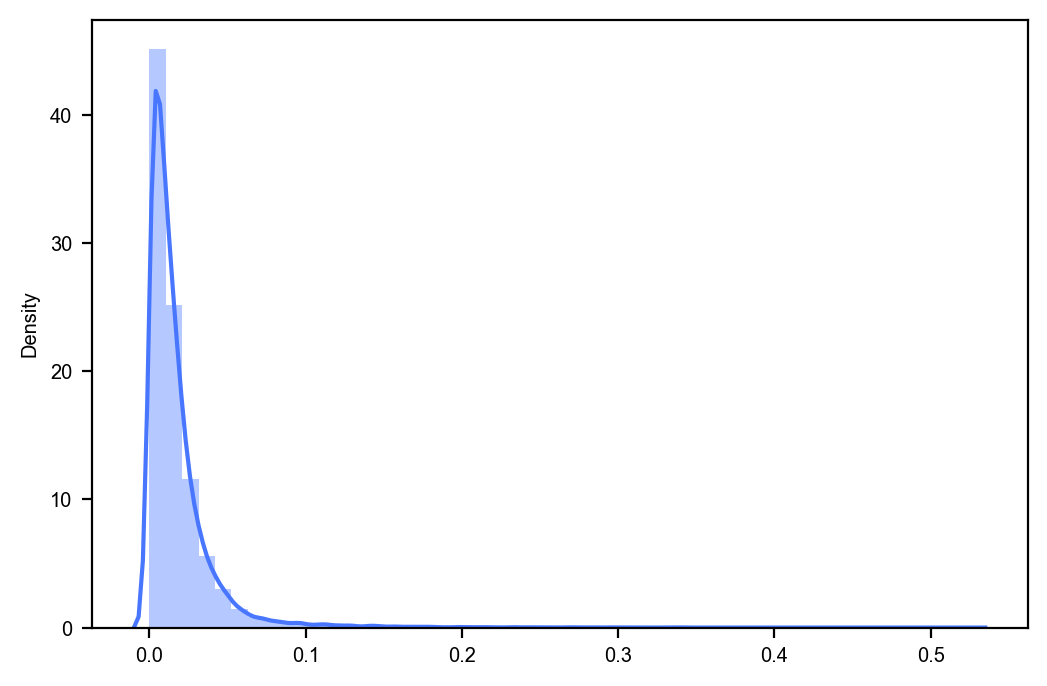

In [13]:
gv = GraphVelo(adata, xkey='M_s', vkey='velocity_S')
gv.train()
gv.write_to_adata(adata)
gv.plot_phi_dist()

In [14]:
adata.layers['velocity_gv'] = gv.project_velocity(adata.layers['M_s'])
adata.obsm['gv_pca'] = gv.project_velocity(adata.obsm['X_pca'])
adata.obsm['gv_umap'] = gv.project_velocity(adata.obsm['X_umap'])

projecting velocity vector to low dimensional embedding: 100%|██████████| 1454/1454 [00:03<00:00, 466.36it/s]
projecting velocity vector to low dimensional embedding: 100%|██████████| 1454/1454 [00:00<00:00, 21552.88it/s]
projecting velocity vector to low dimensional embedding: 100%|██████████| 1454/1454 [00:00<00:00, 17662.32it/s]


|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----------> plotting with basis key=X_umap


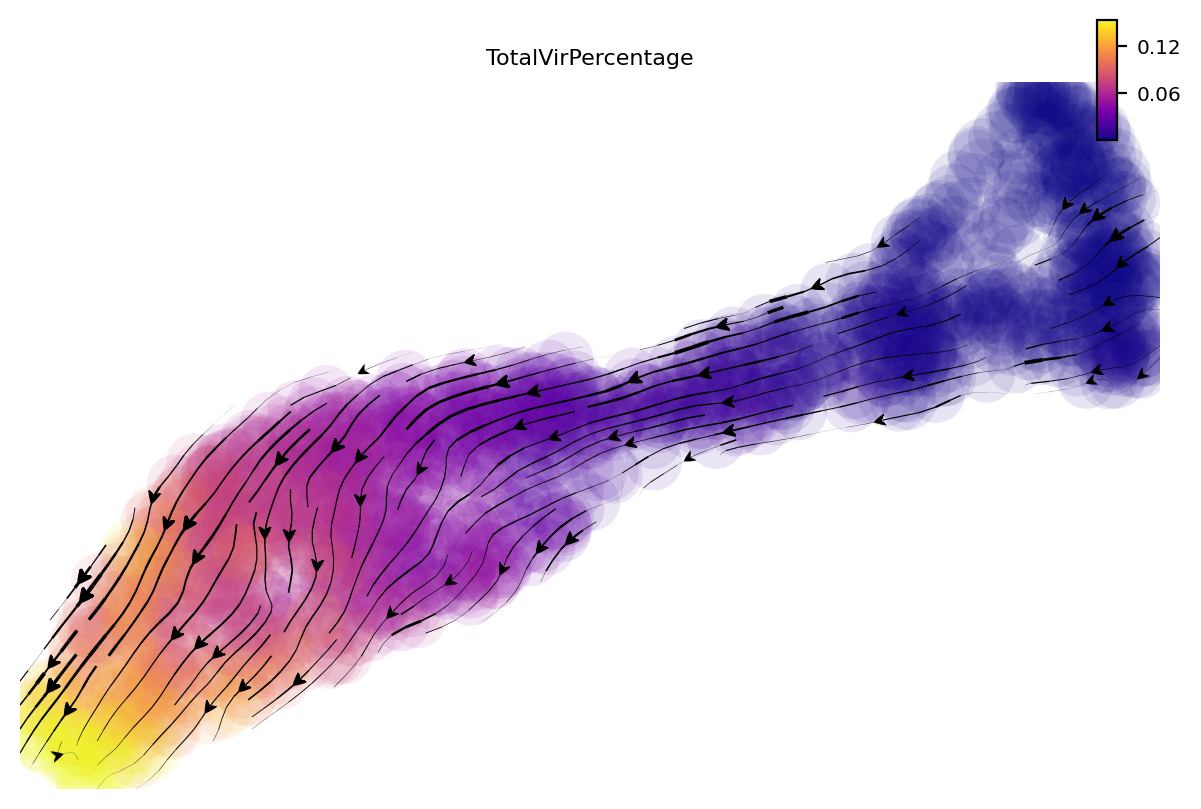

In [15]:
dyn.pl.streamline_plot(adata, color=['TotalVirPercentage'], vector='gv', cmap='plasma')

In [16]:
vdata = adata[:, viral_genes_names].copy()
vdata

/opt/anaconda3/envs/gv-reprod/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 1454 × 67
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_Protein', 'nFeature_Protein', 'batch', 'percent.mt', 'Demultiplex', 'TotalVir', 'TotalVirPercentage', 'CD45', 'HLA.DR', 'HCMV.Status', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters', 'clusters', 'donor', 'Cluster.Type', 'annot', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'initial_unspliced_cell_size', 'unspliced_Size_Factor', 'initial_spliced_cell_size', 'spliced_Size_Factor', 'initial_cell_size', 'Size_Factor', 'ntr', 'cell_cycle_phase'
    var: 'nCells', 'nCounts', 'pass_basic_filter', 'score', 'log_cv', 'log_m', 'frac', 'use_for_pca', 'ntr', 'use_for_dynamics'
    uns: 'genes_to_use', 'pp', 'velocyto_SVR', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_fit', 'feature_selection', 'cell_phase_order', 'cell_phase_genes', 'vel_params_names', 'dynamics', 'neighbors', 'gv_params'
    obsm: 'X_umap', 'X_pca', 'X', 'cell_cycle_scores', 'gv_pca', 'gv_u

|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [0.2365s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.1600s]
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----------> plotting with basis key=X_umap


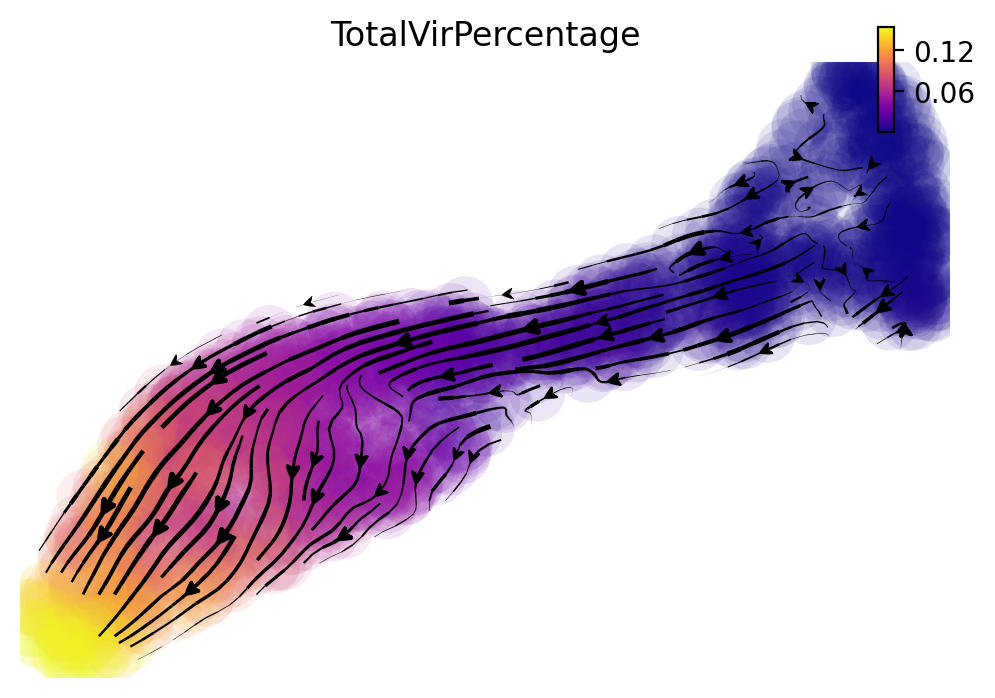

In [17]:
dyn.tl.cell_velocities(vdata, vkey='velocity_gv', X=vdata.layers['M_s'], V=vdata.layers['velocity_gv'], enforce=True)
ax = dyn.pl.streamline_plot(vdata, color='TotalVirPercentage', cmap='plasma', save_show_or_return='return')
# plt.savefig("figures_sup/viral_vf.svg", dpi=300, transparent=True)
plt.show()

In [18]:
adata = adata[:, adata.var['use_for_pca']]
adata

View of AnnData object with n_obs × n_vars = 1454 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_Protein', 'nFeature_Protein', 'batch', 'percent.mt', 'Demultiplex', 'TotalVir', 'TotalVirPercentage', 'CD45', 'HLA.DR', 'HCMV.Status', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters', 'clusters', 'donor', 'Cluster.Type', 'annot', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'initial_unspliced_cell_size', 'unspliced_Size_Factor', 'initial_spliced_cell_size', 'spliced_Size_Factor', 'initial_cell_size', 'Size_Factor', 'ntr', 'cell_cycle_phase'
    var: 'nCells', 'nCounts', 'pass_basic_filter', 'score', 'log_cv', 'log_m', 'frac', 'use_for_pca', 'ntr', 'use_for_dynamics'
    uns: 'genes_to_use', 'pp', 'velocyto_SVR', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_fit', 'feature_selection', 'cell_phase_order', 'cell_phase_genes', 'vel_params_names', 'dynamics', 'neighbors', 'gv_params'
    obsm: 'X_umap', 'X_pca', 'X', 'cell_cycle_scores', 'gv_p

### Calculate MacK score

In [19]:
mack_score(adata, ekey='M_s', vkey='velocity_gv', tkey='TotalVirPercentage')

calculating manifold-consistent scores in 10 cpu(s):  40%|███▉      | 790/2000 [00:12<00:20, 58.73it/s]/opt/anaconda3/envs/gv-reprod/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
calculating manifold-consistent scores in 10 cpu(s): 100%|██████████| 2000/2000 [00:34<00:00, 58.01it/s]
/opt/anaconda3/envs/gv-reprod/lib/python3.8/site-packages/graphvelo/utils.py:540: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var[velo_conf_key] = np.nan


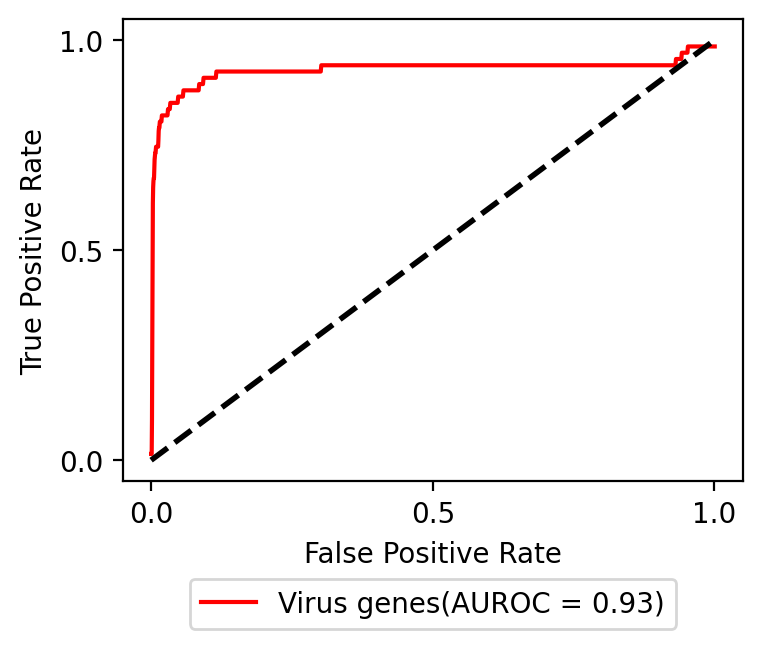

In [20]:
sort_val = adata.var['mack_score'].sort_values(ascending=False)
is_virg = sort_val.index.isin(viral_genes_names)
tpr_vir = [] 
fpr_vir = []
for cutoff in range(1, len(sort_val) + 1):
    tp_vir = np.sum(is_virg[:cutoff])
    fp_vir = cutoff - tp_vir
    tpr_vir.append(tp_vir / len(viral_genes_names))
    fpr_vir.append(fp_vir / (len(sort_val)-len(viral_genes_names)))
auroc_vir = np.trapz(tpr_vir, fpr_vir)
plt.figure(figsize=(4, 3))
sns.lineplot(x=fpr_vir, y=tpr_vir, label=f'Virus genes(AUROC = {auroc_vir:.2f})', color='red')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xticks([0, 0.5, 1.0])
plt.yticks([0, 0.5, 1.0])
plt.grid(False)
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.35), ncol=1, prop={'size': 10})
# plt.savefig('figures_sup/viral_gene_prediction.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

Fitting trends using GAM: 100%|██████████| 2/2 [00:00<00:00, 48.07it/s]


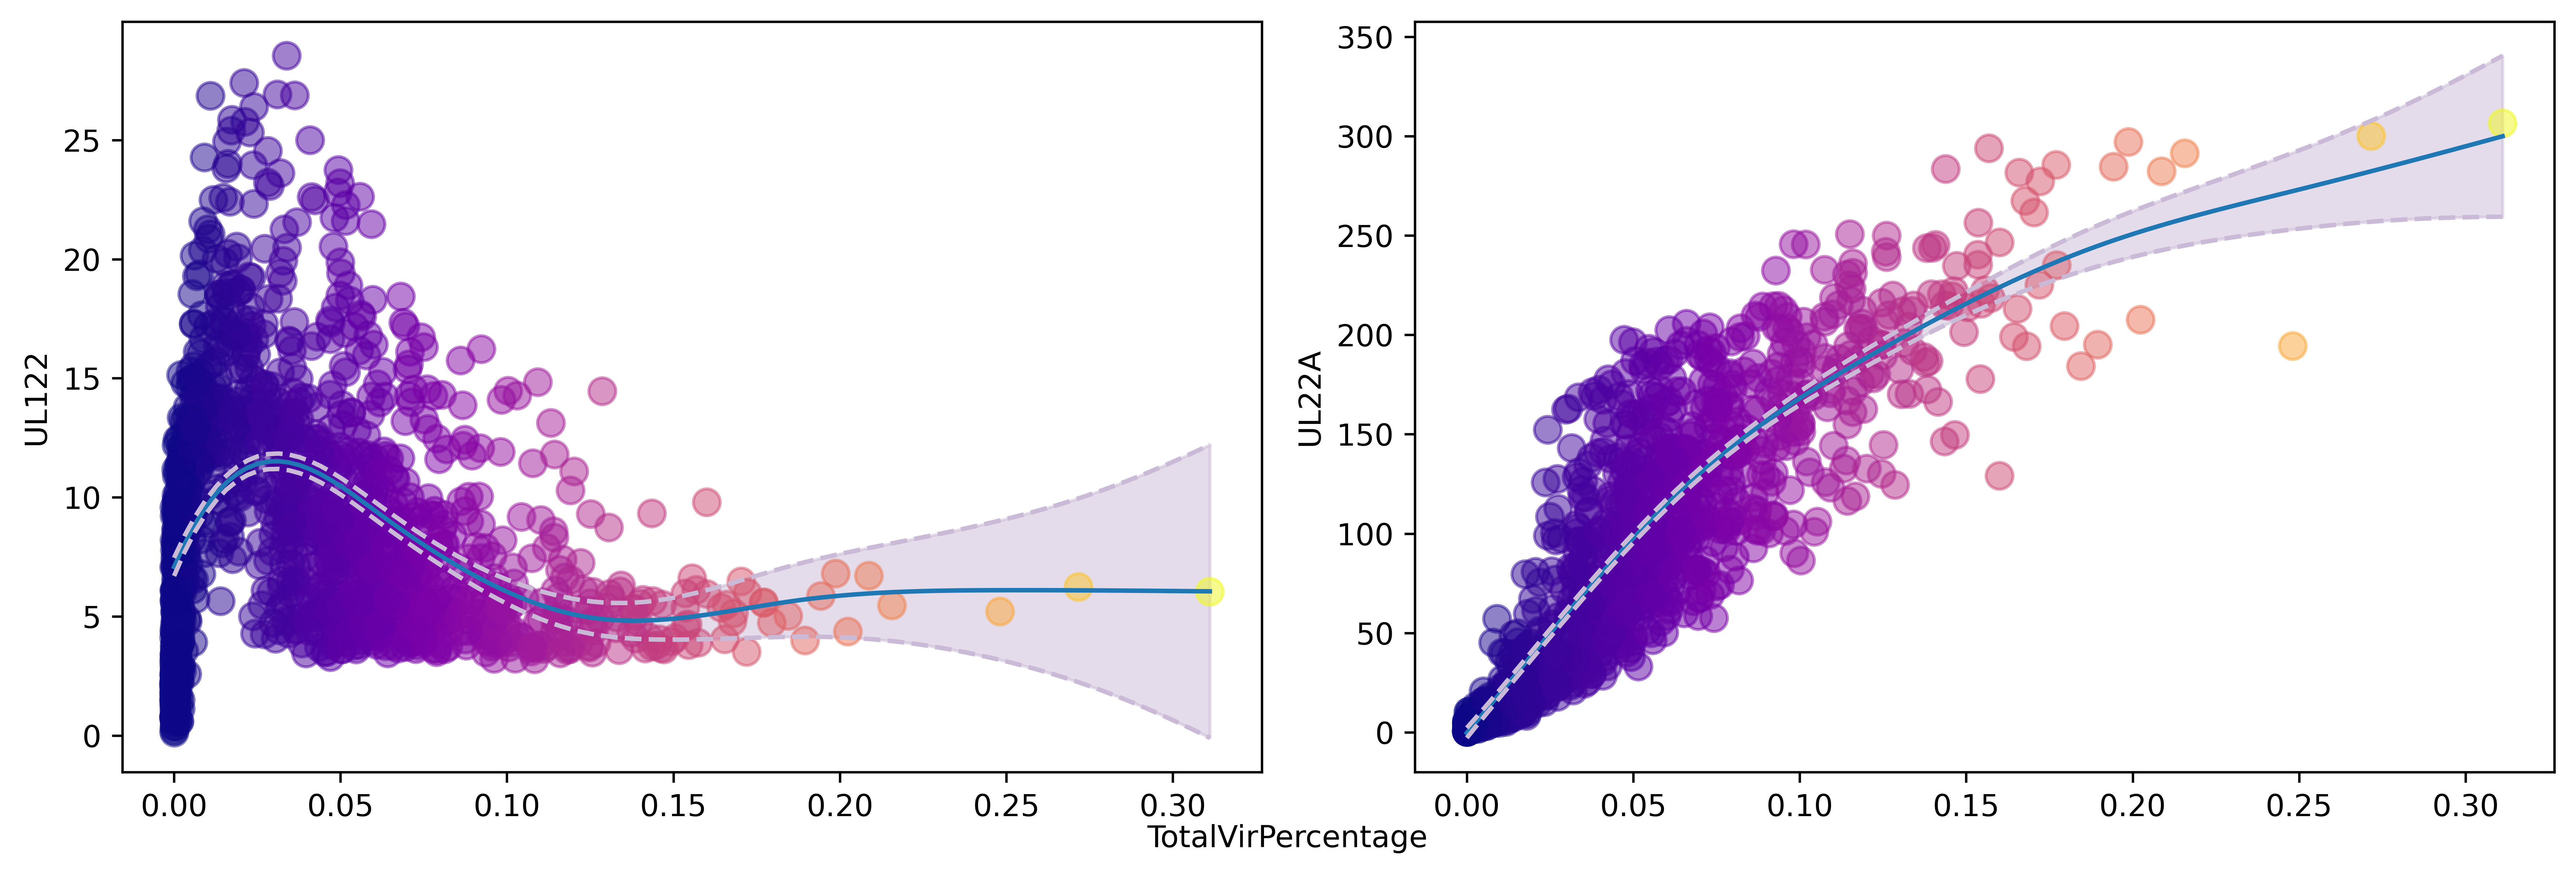

Fitting trends using GAM: 100%|██████████| 2/2 [00:00<00:00, 75.51it/s]


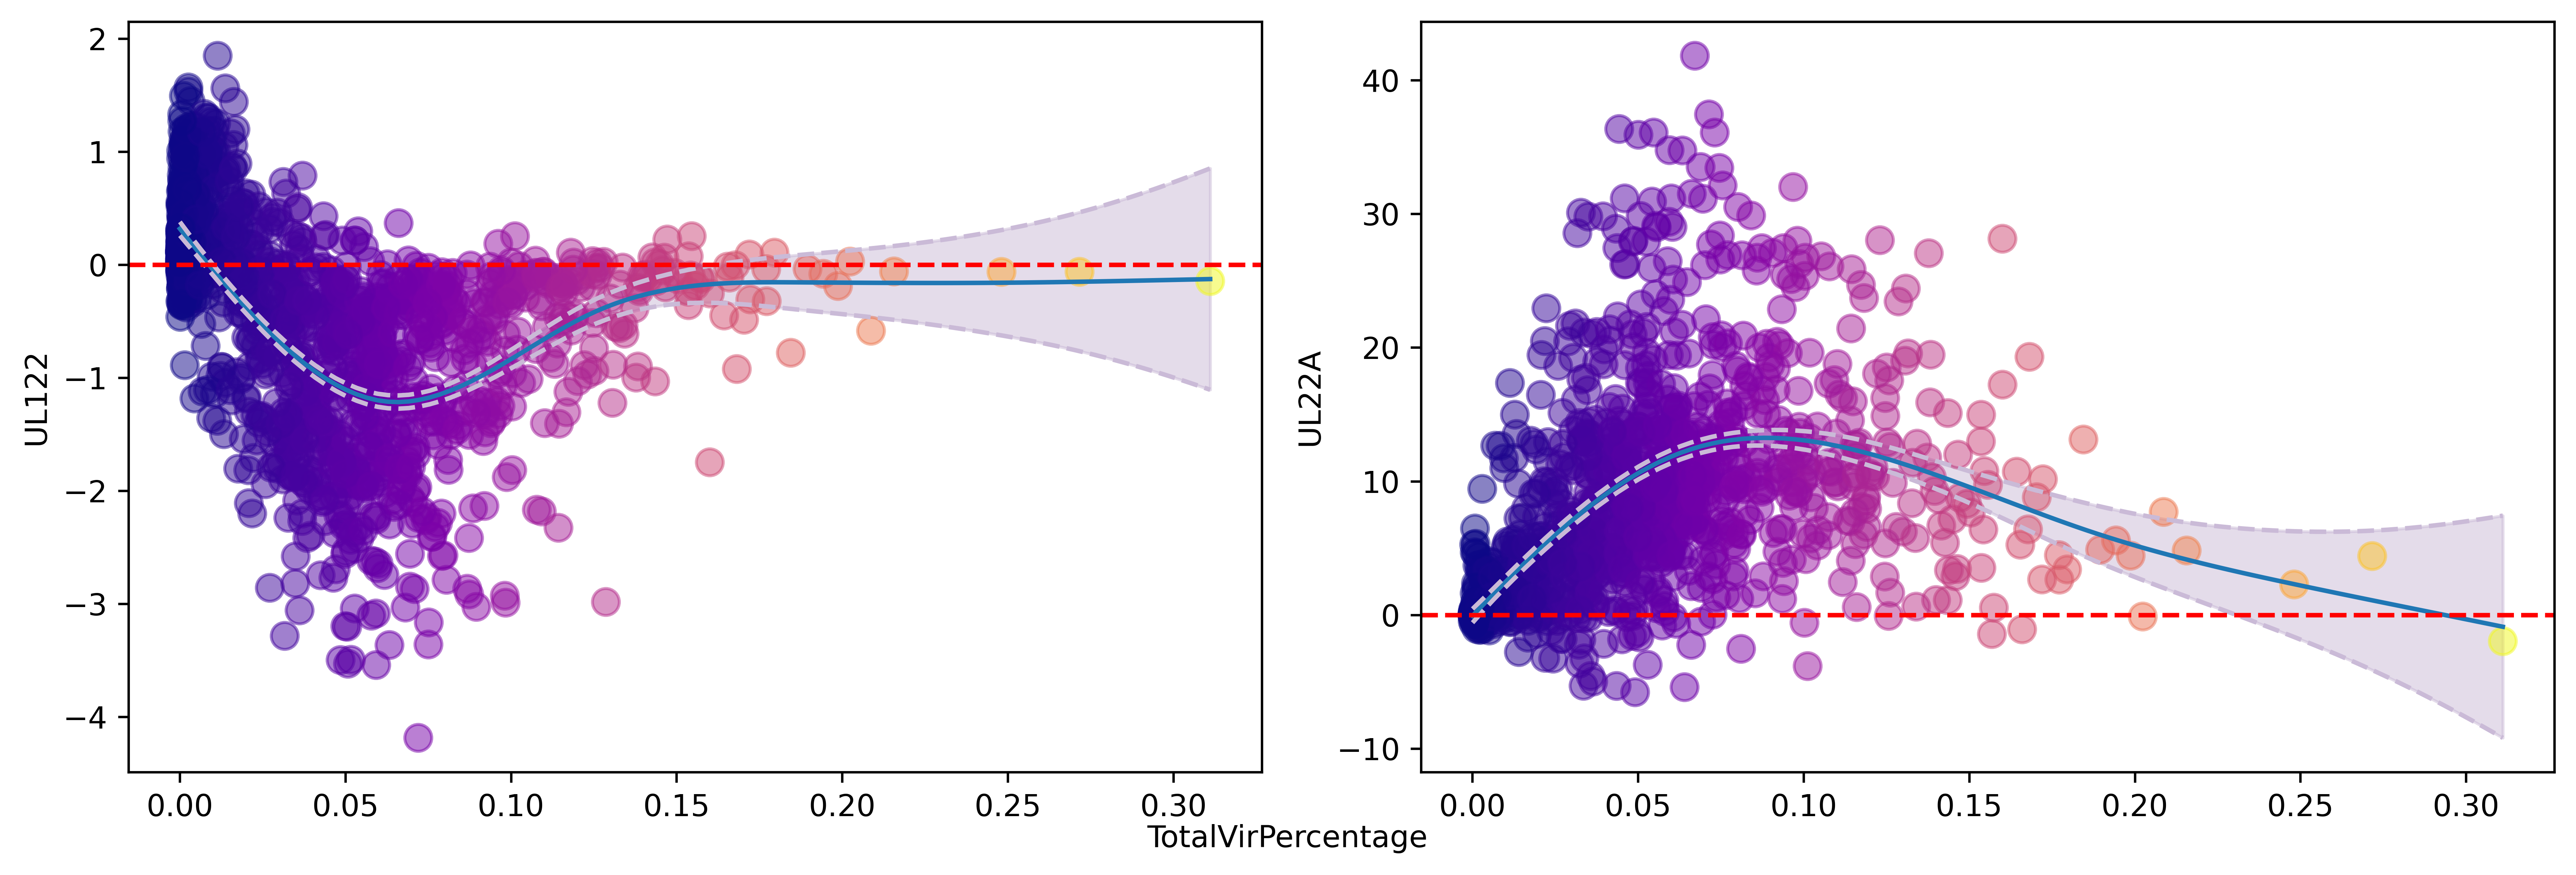

In [21]:
gene_trend(adata, ['UL122', 'UL22A'], layer='M_s', tkey='TotalVirPercentage', color='TotalVirPercentage', n_splines=8, pointsize=80, dpi=300)
plt.xlabel('')
# plt.savefig("figures_v2/gene_trend.pdf", dpi=300, transparent=True)
plt.show()
gene_trend(adata, ['UL122', 'UL22A'], layer='velocity_gv', tkey='TotalVirPercentage', color='TotalVirPercentage', zero_indicator=True, n_splines=8, pointsize=80, dpi=300)
plt.xlabel('')
# plt.savefig("figures_v2/velo_trend.pdf", dpi=300, transparent=True)
plt.show()

In [22]:
host_genes = ~pd.Series(adata.var_names).isin(viral_genes_names.tolist()).values
viral_genes = pd.Series(adata.var_names).isin(viral_genes_names.tolist()).values
host_genes_names = adata.var_names[host_genes]
viral_genes_names = adata.var_names[viral_genes]

## Fit velocity trends for gene module exploring

In [23]:
from graphvelo.gam import fit_gene_trend

In [24]:
gdata = fit_gene_trend(adata[adata.obs.annot=='I'], adata.var_names, 'TotalVirPercentage', layer='velocity_gv', grid_num=100)

Fitting trends using GAM: 100%|██████████| 2000/2000 [00:16<00:00, 121.25it/s]


In [25]:
annot = []
for i in gdata.obs.index:
    if i in viral_genes_names:
        annot.append('viral gene')
    else:
        annot.append('host gene')
gdata.obs['annot'] = pd.Categorical(annot)

In [26]:
gdata.write("gdata.h5ad")

## VF analyses

### Vector field pseudotime

In [27]:
adata.obsm['velocity_umap'] = adata.obsm['gv_umap'].copy() # adata_gv
dyn.vf.VectorField(adata, basis='umap', M=100, pot_curl_div=True)

|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: UMAP. 
        Vector field will be learned in the UMAP space.
|-----> Generating high dimensional grids and convert into a row matrix.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----> [SparseVFC] completed [9.1888s]
|-----> Running ddhodge to estimate vector field based pseudotime in umap basis...
|-----> graphizing vectorfield...
|-----------? nbrs_idx argument is ignored and recomputed because nbrs_idx is not None and return_nbrs=True
|-----------> calculating neighbor indices...
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----> [ddhodge completed] completed [1.3224s]
|-----> Computing curl...


Calculating 2-D curl: 100%|██████████| 1454/1454 [00:00<00:00, 31708.62it/s]

|-----> Computing divergence...



Calculating divergence: 100%|██████████| 2/2 [00:00<00:00, 39.26it/s]

|-----> [VectorField] completed [10.6716s]


In [28]:
tmp = dyn.read('gv_dyn_scvt.h5ad')
adata.obs['latent_time'] = tmp[adata.obs_names].obs['latent_time'].copy()
del tmp

In [29]:
df = adata.obs[['umap_ddhodge_potential', 'TotalVirPercentage', 'latent_time']]
df.columns = ['GraphVelo pseudotime', 'Viral loading', 'scVelo latent time']

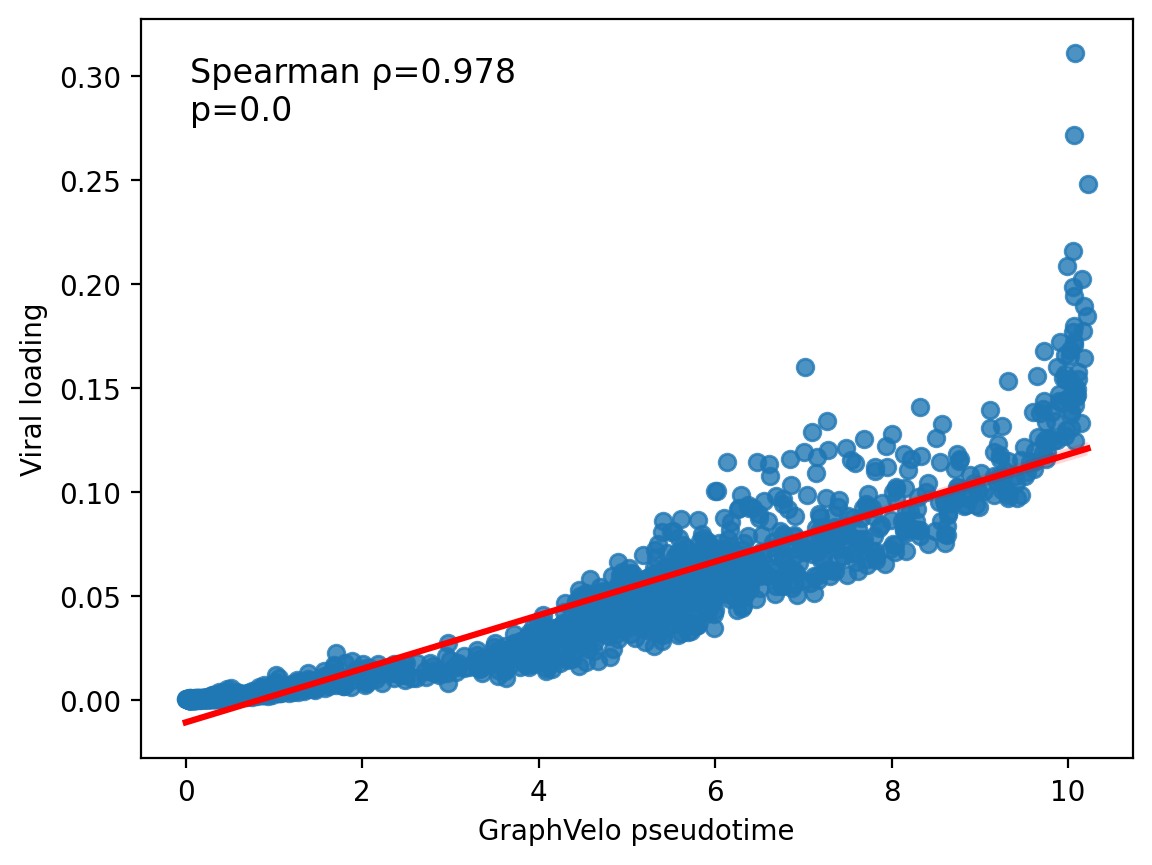

In [30]:
import scipy
res = scipy.stats.spearmanr(df['GraphVelo pseudotime'], df['Viral loading'])
ax = sns.regplot(df, x='GraphVelo pseudotime', y='Viral loading', line_kws=dict(color="r"))
ax.text(0.05, 0.95, s=f'Spearman \u03C1={res[0]:.3f}\np=0.0', transform=ax.transAxes, fontsize=12, color='black', verticalalignment='top')
# plt.savefig('figures_v2/graphvelo_time.pdf', format='pdf', dpi=300)
plt.show()

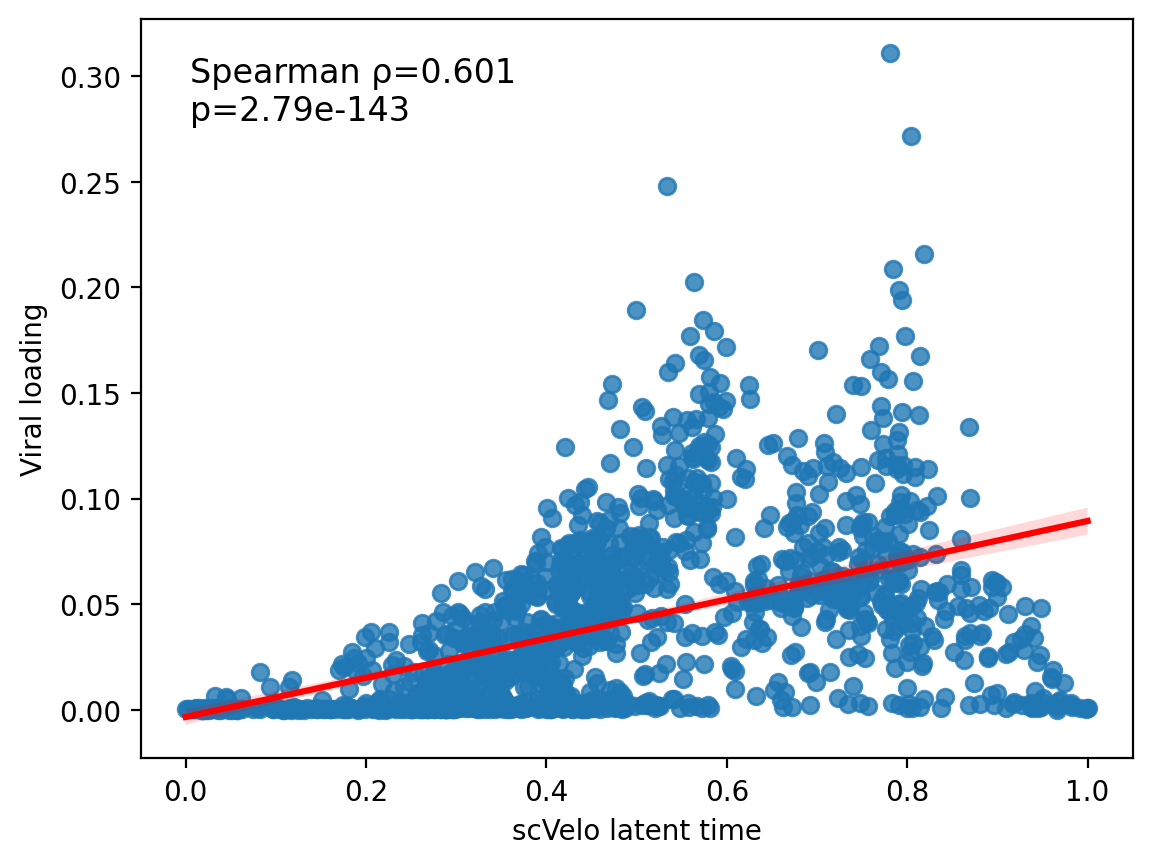

In [31]:
res = scipy.stats.spearmanr(df['scVelo latent time'], df['Viral loading'])
ax = sns.regplot(df, x='scVelo latent time', y='Viral loading', line_kws=dict(color="r"))
ax.text(0.05, 0.95, s=f'Spearman \u03C1={res[0]:.3f}\np=2.79e-143', transform=ax.transAxes, fontsize=12, color='black', verticalalignment='top')
# plt.savefig('figures_v2/scvelo_time.pdf', format='pdf', dpi=300)
plt.show()

## Jacobian analyses

In [32]:
adata.obsm['velocity_pca'] = adata.obsm['gv_pca'].copy()
dyn.vf.VectorField(adata, basis='pca', M=500)

|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: PCA. 
        Vector field will be learned in the PCA space.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> [SparseVFC] completed [3.0252s]
|-----> [VectorField] completed [3.0739s]


In [33]:
vir_genes = [i for i in viral_genes_names if i in adata.var_names]
host_genes = [i for i in host_genes_names if i in adata.var_names]
len(vir_genes), len(host_genes)

(66, 1934)

In [34]:
dyn.vf.jacobian(
    adata,
    basis='pca',
    regulators=vir_genes,
    effectors=host_genes)
full_reg_rank = dyn.vf.rank_jacobian_genes(adata,
                                           mode="full_reg",
                                           output_values=False,
                                           abs=False,
                                           return_df=True)['all']

Transforming subset Jacobian: 100%|██████████| 1454/1454 [00:03<00:00, 460.26it/s]


In [35]:
rank_reg = full_reg_rank.apply(lambda x: pd.Series(range(1, len(x) + 1), index=x))
average_rank = rank_reg.mean(axis=1)
final_rank_reg = average_rank.sort_values() # top regulators in viral genome

In [36]:
dyn.vf.jacobian(
    adata,
    basis='pca',
    regulators=host_genes,
    effectors=vir_genes)
full_eff_rank = dyn.vf.rank_jacobian_genes(adata,
                                           mode='full_eff',
                                           exclude_diagonal=True,
                                           output_values=False,
                                           abs=False,
                                           return_df=True)['all']

Transforming subset Jacobian: 100%|██████████| 1454/1454 [00:01<00:00, 1056.15it/s]


In [37]:
rank_eff = full_eff_rank.apply(lambda x: pd.Series(range(1, len(x) + 1), index=x))
avg_rank = rank_eff.mean(axis=1)
final_rank_eff = avg_rank.sort_values()

In [38]:
# Reactome pathways
IFN_ALPHA_BETA = ['IRF1', 'IFIT2', 'SOCS3', 'EGR1', 'ISG20', 'PTPN1', 'TYK2', 'SOCS1', 'IFNAR1', 'IRF9', 'STAT2', 'PTPN11', 'STAT1', 'KPNB1', 'IFITM3', 'RNASEL', 'IFNB1', 'PTPN6', 'JAK1', 'OAS1', 'IRF2', 'IFI35', 'IFIT3', 'IFITM2', 'IFI27', 'HLA-C', 'MX1', 'IFITM1', 'PSMB8', 'IRF7', 'ISG15', 'ADAR', 'OASL', 'GBP2', 'USP18', 'RSAD2', 'BST2', 'HLA-B', 'MX2', 'OAS3', 'IFNAR2', 'HLA-A', 'HLA-G', 'XAF1', 'IRF4', 'IRF5', 'IRF8', 'IFIT1', 'SAMHD1', 'OAS2', 'ABCE1', 'IP6K2', 'HLA-F', 'IRF6', 'HLA-E', 'IFI6', 'IFIT5', 'IRF3', 'KPNA1', 'HLA-H', 'IFNA2', 'IFNA14', 'IFNA13', 'IFNA6', 'IFNA21', 'IFNA7', 'IFNA5', 'IFNA17', 'IFNA16', 'IFNA4', 'IFNA8', 'IFNA10']
IFN_GAMMA = ['IRF1', 'IFNGR2', 'ICAM1', 'CD44', 'SOCS3', 'MT2A', 'MID1', 'SMAD7', 'PTPN1', 'PTPN2', 'SOCS1', 'IFNGR1', 'IRF9', 'PTPN11', 'STAT1', 'PML', 'JAK2', 'PTPN6', 'TRIM29', 'JAK1', 'PIAS1', 'B2M', 'NCAM1', 'CAMK2B', 'OAS1', 'IRF2', 'HLA-C', 'TRIM14', 'TRIM21', 'IRF7', 'GBP4', 'TRIM26', 'TRIM5', 'OASL', 'GBP2', 'TRIM25', 'IFI30', 'VCAM1', 'HLA-B', 'OAS3', 'HLA-A', 'HLA-DRB1', 'HLA-G', 'GBP6', 'IRF4', 'IRF5', 'HLA-DQA1', 'IRF8', 'FCGR1A', 'OAS2', 'CIITA', 'PRKCD', 'PTAFR', 'HLA-F', 'TRIM10', 'IRF6', 'IFNG', 'HLA-E', 'HLA-DRA', 'FCGR1BP', 'TRIM45', 'GBP7', 'GBP1', 'GBP3', 'GBP5', 'TRIM62', 'TRIM46', 'TRIM17', 'CAMK2G', 'TRIM8', 'TRIM6', 'TRIM34', 'TRIM68', 'TRIM22', 'TRIM3', 'TRIM48', 'IRF3', 'SUMO1', 'SP100', 'CAMK2D', 'TRIM2', 'CAMK2A', 'HLA-DPA1', 'HLA-DQA2', 'HLA-DQB2', 'HLA-DQB1', 'HLA-DPB1', 'HLA-DRB5', 'TRIM38', 'HLA-H', 'TRIM31', 'TRIM35', 'HLA-DRB4', 'HLA-DRB3']
NFKB = ['TP53', 'CASP8', 'UBC', 'CHUK', 'USP18', 'NLRC5', 'IKBKG', 'USP14', 'TRAF2', 'IKBKB', 'TRAF6', 'NLRX1', 'IKBIP', 'N4BP1', 'UBB', 'UBA52', 'RPS27A', 'LRRC14']
STING = ['DTX4', 'XRCC6', 'XRCC5', 'TRIM21', 'TBK1', 'MRE11', 'PRKDC', 'IFI16', 'STAT6', 'NLRC3', 'IRF3', 'NLRP4', 'TREX1', 'STING1', 'DDX41', 'CGAS']
TNF_NFKB = [i for i in ['TNF', 'TNFRSF1A', 'RIPK1', 'TRADD', 'TRAF2', 'TRAF5', 'TAB1', 'TAB2', 'TAB3', 'MAP3K7', 'CHUK', 'IKBKB', 'IKBKG', 'NFKBIA', 'NFKB1', 'RELA'] if i in host_genes]

In [39]:
valid_genes = final_rank_reg.head(20).index.tolist()
valid_targets = TNF_NFKB+IFN_ALPHA_BETA+IFN_GAMMA+STING

In [40]:
dyn.vf.jacobian(
    adata,
    basis='pca',
    regulators=vir_genes,
    effectors=host_genes)
full_eff_rank = dyn.vf.rank_jacobian_genes(adata,
                                           mode="full_eff",
                                           output_values=False,
                                           abs=True,
                                           return_df=True)['all']

Transforming subset Jacobian: 100%|██████████| 1454/1454 [00:03<00:00, 466.59it/s]


In [41]:
vir_top_eff = full_eff_rank.tail(50)

In [42]:
ifn_ab = [i for i in IFN_ALPHA_BETA if i in host_genes]
ifn_g = [i for i in IFN_GAMMA if i in host_genes]
nfkb = [i for i in TNF_NFKB if i in host_genes]
sting=[i for i in STING if i in host_genes]
valid_vir_genes = ['UL7-13', 'UL16-17', 'UL22A', 'UL23as', 'UL26-30', 'UL31', 'UL35', 'UL40-41A', 'UL42-44', 'UL72/74', 'UL76-78', 'UL82-83', 'UL95-99', 'UL103-104', 'UL111A', 'UL115-121', 'UL122', 'UL123+mNeon', 'UL139-141', 'UL144-145', 'US10/11', 'US12-17', 'US18-20', 'US27-28'] # adapted from immune evasion related
valid_targets = ifn_ab+ifn_g+nfkb+sting

In [43]:
labels = vir_genes+['IFN_ALPHA_BETA', 'IFN_GAMMA', 'NFKB', 'STING']+valid_targets

In [44]:
dyn.vf.jacobian(adata, vir_genes, host_genes) 
eff_rank = dyn.vf.rank_jacobian_genes(adata,
                                           mode="full_eff",
                                           output_values=False,
                                           abs=False,
                                           return_df=True)['all']
vir_top_eff = eff_rank.tail(50)

Transforming subset Jacobian: 100%|██████████| 1454/1454 [00:03<00:00, 382.01it/s]


In [45]:
valid_targets = [i for i in valid_targets if i in np.unique(vir_top_eff.values)]

In [46]:
def show_st(labels, patterns, patterns_str, rank_df, threshold=1):
    import plotly.graph_objects as go
    # Dictionary to count the frequency of connections
    connection_counts = {}
    color_map = ["rgba(202, 186, 215, 0.8)", "rgba(255, 127, 14, 0.6)",
              "rgba(148, 103, 189, 0.8)", "rgba(252, 204, 202, 1)",
              "rgba(227, 119, 194, 0.8)"]

    for i, gene in enumerate(labels):
        if gene in vir_genes:
            for t in rank_df[gene].values:
                if t in labels:
                    for j, pattern in enumerate(patterns):
                        if t in pattern:
                            # Define the connection as a tuple (source, target)
                            connection = (i, labels.index(patterns_str[j]))
                            reverse_connection = (labels.index(patterns_str[j]), labels.index(t))
                            
                            # Increment frequency count for both directions
                            if connection in connection_counts:
                                connection_counts[connection] += 1
                            else:
                                connection_counts[connection] = 1
                            
                            if reverse_connection in connection_counts:
                                connection_counts[reverse_connection] += 1
                            else:
                                connection_counts[reverse_connection] = 1
                else:
                    continue
        else:
            continue

    # Filter connections based on the threshold
    source = []
    target = []
    link_c = []
    for connection, count in connection_counts.items():
        if count >= threshold:
            source.append(connection[0])
            target.append(connection[1])
            if labels[connection[0]] in patterns_str:
                link_c.append(color_map[patterns_str.index(labels[connection[0]])])
            elif labels[connection[1]] in patterns_str:
                link_c.append(color_map[patterns_str.index(labels[connection[1]])])
            else:
                link_c.append(color_map[-1])

    data = go.Sankey(
        node=dict(
            label=labels,
        ),
        link=dict(
            source=source,
            target=target,
            value=[connection_counts[conn] for conn in zip(source, target)],  # or use the actual count if you prefer
            color=link_c
        ))

    fig = go.Figure(data=data)
    fig.update_layout(title_text="", font_size=8)
    # fig.write_image("figures_v2/sankey_diagram.pdf", width=600, height=800, scale=3)
    fig.show()

In [47]:
show_st(labels, [ifn_ab,ifn_g,nfkb], ['IFN_ALPHA_BETA', 'IFN_GAMMA', 'NFKB',], vir_top_eff, 1)
# PMC10458407

## Perturbation analyses implemented by dynamo. 

In [48]:
%%capture
delta_vrna = np.zeros((len(viral_genes_names), adata.n_obs))
for i, gene in enumerate(viral_genes_names):
    dyn.pd.perturbation(adata, gene, [-10], emb_basis="umap", projection_method='cosine')
    delta_vrna[i] = adata[:, viral_genes_names].layers['j_delta_x_perturbation'].A.sum(1)

|-----> In silico perturbation of single-cells and prediction of cell fate after perturbation...
|-----> Retrive X_pca, PCs, pca_mean...
|-----> Calculate perturbation effect matrix via \delta Y = J \dot \delta X....
|-----> project the pca perturbation vector to low dimensional space....
|-----> [calculating transition matrix via cosine kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via cosine kernel with sqrt transform.] completed [0.2907s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.1684s]
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----> you can use dyn.pl.streamline_plot(adata, basis='umap_perturbation') to visualize the perturbation vector
|-----> In silico perturbation of single-cells and prediction of cell fate after perturbation...
|-----> Retrive X_pca, PC

In [49]:
mean_delta_vrna = np.mean(delta_vrna, axis=1)
sorted_ind = np.argsort(mean_delta_vrna)
np.array(viral_genes_names)[sorted_ind[:10]]

array(['UL123+mNeon', 'RL3?', 'UL55-57', 'UL48A-51', 'UL22A', 'UL124',
       'UL84-86', 'UL111A', 'UL87-94', 'UL40-41A'], dtype=object)

In [50]:
sort_vgene = np.array(viral_genes_names)[sorted_ind]
df = pd.DataFrame(
    {'Viral Gene': [i for i in sort_vgene for _ in range(adata.n_obs)],
     'delta_vrna': delta_vrna[sorted_ind].flatten()}
)

/var/folders/zr/17m1_r_x57q5mxr1zs8px9rh0000gn/T/ipykernel_16566/1479404652.py:6: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

/var/folders/zr/17m1_r_x57q5mxr1zs8px9rh0000gn/T/ipykernel_16566/1479404652.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/zr/17m1_r_x57q5mxr1zs8px9rh0000gn/T/ipykernel_16566/1479404652.py:11: UserWarning:

FixedFormatter should only be used together with FixedLocator

/var/folders/zr/17m1_r_x57q5mxr1zs8px9rh0000gn/T/ipykernel_16566/1479404652.py:14: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the 

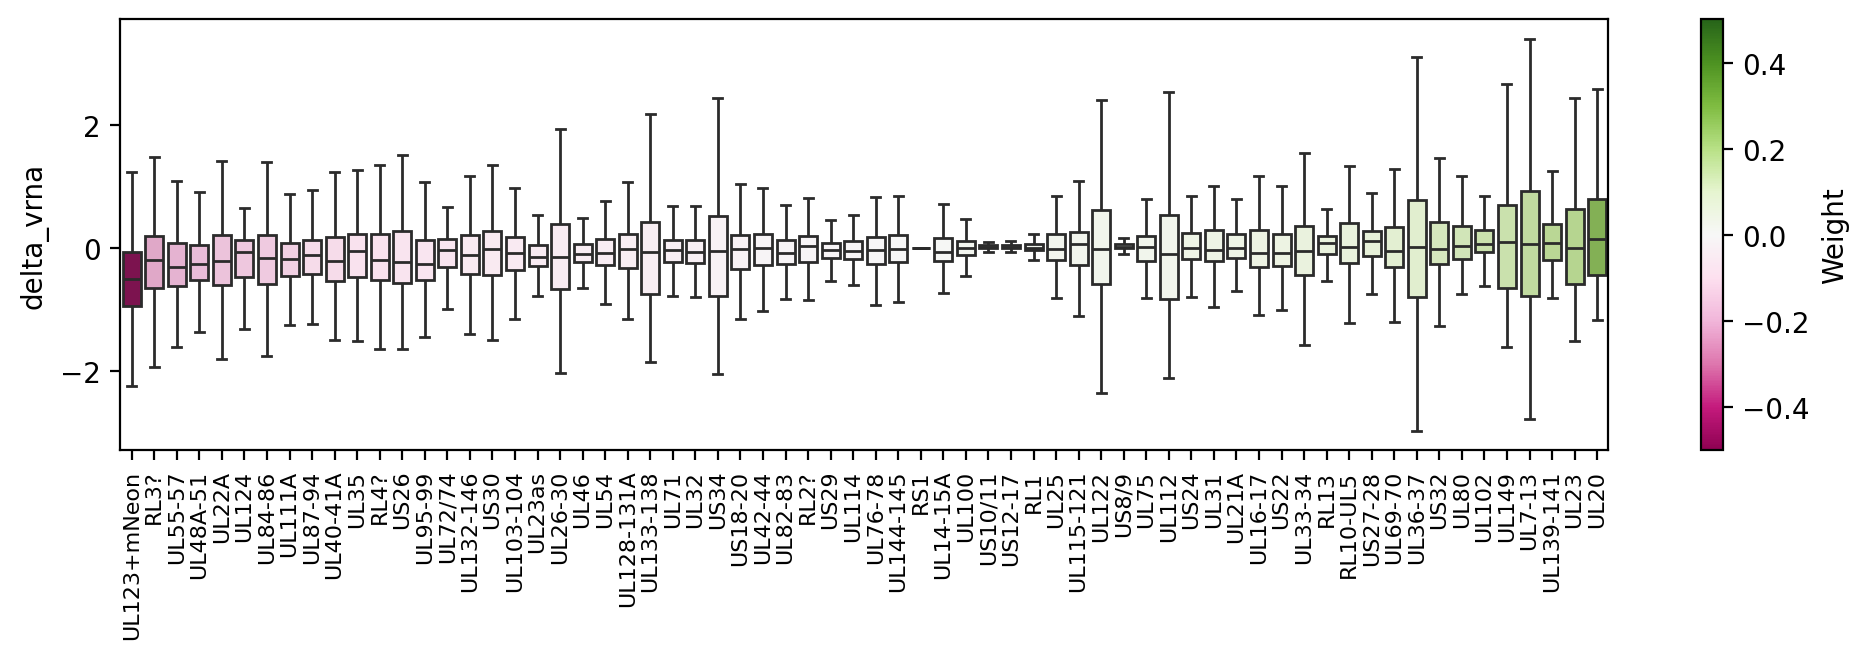

In [51]:
from matplotlib import cm
from matplotlib.colors import Normalize
plt.figure(figsize=(12, 2.8))
abs_max = max(np.abs(min(mean_delta_vrna[sorted_ind])), max(mean_delta_vrna[sorted_ind]))
norm = Normalize(vmin=-np.quantile(abs_max, 0.9), vmax=np.quantile(abs_max, 0.9))
cmap = cm.get_cmap("PiYG")
# Map each weight to an RGB color
colors = [cmap(norm(weight)) for weight in mean_delta_vrna[sorted_ind]]
ax = sns.boxplot(data=df, x="Viral Gene", y="delta_vrna", palette=colors, showfliers=False)
labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90, fontsize=8)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label='Weight')
plt.xlabel('')
plt.yticks([-2, 0, 2])
# plt.savefig("figures_v2/perturb_viralRNA.pdf", dpi=300, transparent=True)
plt.show()

|-----> In silico perturbation of single-cells and prediction of cell fate after perturbation...
|-----> Retrive X_pca, PCs, pca_mean...
|-----> Calculate perturbation effect matrix via \delta Y = J \dot \delta X....
|-----> project the pca perturbation vector to low dimensional space....
|-----> [calculating transition matrix via cosine kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via cosine kernel with sqrt transform.] completed [0.2762s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.1687s]
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----> you can use dyn.pl.streamline_plot(adata, basis='umap_perturbation') to visualize the perturbation vector
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----------> plotting

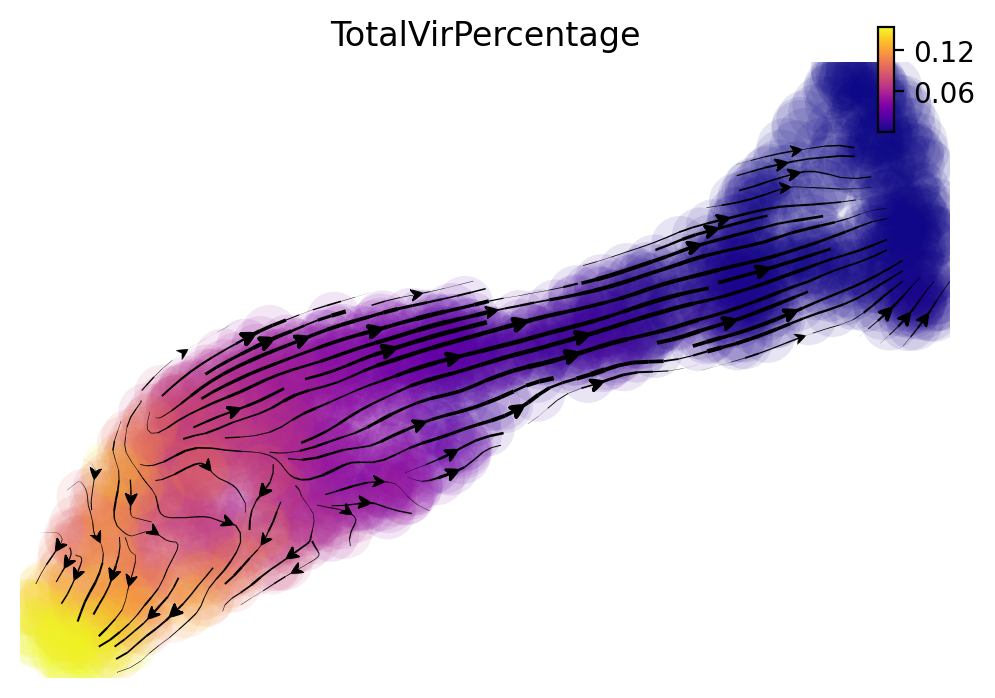

In [52]:
dyn.pd.perturbation(adata, 'UL123+mNeon', [-100], emb_basis="umap", projection_method='cosine')
ax = dyn.pl.streamline_plot(adata, color=['TotalVirPercentage'], basis="umap_perturbation", cmap='plasma', save_show_or_return='return')
plt.show()